In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???
# Milano                               (Italy)              EPSG:6875 ???
# Ljubljana                            (Slovenia)           EPSG:8687 ???

place_name = 'Milano'
case_name = 'municipality'
local_crs = 'EPSG:6875'

In [5]:
output_folder = 'data'
output_sub_folder = '{}_{}_08Nov2022'.format(place_name, case_name)

In [6]:
trip_distances = [300, 500]
buffer = max(trip_distances)

green = '#238443'
trip_colors_green = ['#78c679', '#c2e699']   # ffffcc
orange = '#cc4c02'
trip_colors_orange = ['#fe9929', '#fed98e']   # ffffd4

In [7]:
tolerance = 10

In [53]:
demo = True

if demo:
    xmin = 6779709 - 500
    ymin = 5033468 - 500
    xmax = 6783696 + 500
    ymax = 5035067 + 500

# Load data

In [78]:
if demo:

    p1 = Point(xmin, ymin)
    p2 = Point(xmax, ymin)
    p3 = Point(xmax, ymax)
    p4 = Point(xmin, ymax)
    pointList = [p1, p2, p3, p4, p1]

    bbox_shape = Polygon([[p.x, p.y] for p in pointList])
    
    bbox = gpd.GeoDataFrame(index=[0], crs=local_crs, geometry=[bbox_shape])

In [8]:
# NL
if local_crs == 'EPSG:28992':
    place = gpd.read_file(os.path.join(output_folder, 'WijkBuurtkaart_2022_v0', 'SHP', 'CBS_buurten2022.shp'))
    
    if case_name == 'West':
        WK_NAAM = 'Wijk 01 West'
        BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM) & (place['BU_NAAM']!=BU_NAAM_exclude)]
        
    elif case_name == 'Zuid West':
        WK_NAAM = 'Wijk 08 Zuidwest'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]
    
    elif case_name == 'Zuid':
        WK_NAAM = 'Wijk 07 Zuid'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]
    
    elif case_name == 'three districts':
        BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM'].isin(['Wijk 01 West', 'Wijk 08 Zuidwest', 'Wijk 07 Zuid'])) & (place['BU_NAAM']!=BU_NAAM_exclude)]

    elif case_name == 'municipality':
        place = place[(place['GM_NAAM']==place_name)]
        
# not NL
else:
    place = ox.geocode_to_gdf(place_name).to_crs(local_crs)

In [9]:
place = gpd.GeoDataFrame(index=[0], crs=local_crs, geometry=[place.unary_union])

<AxesSubplot:>

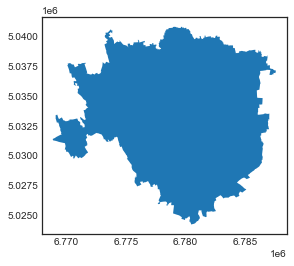

In [10]:
place.plot()

In [11]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### Pedestrian network

In [12]:
# custom filter: using the osmnx network_type 'walk' as a basis,
# but NOT excluding 'cycleways'.
# see https://github.com/gboeing/osmnx/blob/main/osmnx/downloader.py
# and https://github.com/gboeing/osmnx/issues/169
network_filter = (
        f'["highway"]["area"!~"yes"]["access"!~"private"]'
        f'["highway"!~"abandoned|bus_guideway|construction|motor|planned|platform|proposed|raceway"]'
        f'["foot"!~"no"]["service"!~"private"]'
    )

In [102]:
if demo:
    bbox_osm = bbox.to_crs('EPSG:4326')
    
    G_demo = ox.graph_from_polygon(bbox_osm.geometry.unary_union, network_type='walk', custom_filter=network_filter, retain_all=True)
    G_demo = ox.project_graph(G_demo, to_crs=local_crs)
    
    paths_demo = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_demo), nodes=False, edges=True).to_crs(local_crs)
    
else:
    G = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter, retain_all=True)
    G = ox.project_graph(G, to_crs=local_crs)

    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True).to_crs(local_crs)

### Barriers

In [17]:
highway_speed_barrier_50 = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_50.geojson'))
highway_speed_barrier_50.crs = local_crs

highway_speed_barrier_60more = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_60more.geojson'))
highway_speed_barrier_60more.crs = local_crs

In [22]:
highway_type_barrier_major = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_major.geojson'))
highway_type_barrier_major.crs = local_crs

if place_name != "Milano":
    highway_type_barrier_bus = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_bus.geojson'))
    highway_type_barrier_bus.crs = local_crs

highway_type_barrier_12 = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_12.geojson'))
highway_type_barrier_12.crs = local_crs

highway_type_barrier_3 = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_3.geojson'))
highway_type_barrier_3.crs = local_crs

In [23]:
railway_barrier_tram = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_tram.geojson'))
railway_barrier_tram.crs = local_crs

railway_barrier_other = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_other.geojson'))
railway_barrier_other.crs = local_crs

In [24]:
natural_barrier_blue = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_blue.geojson'))
natural_barrier_blue.crs = local_crs

natural_barrier_parks_large = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_parks_large.geojson'))
natural_barrier_parks_large.crs = local_crs

natural_barrier_green_large = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_green_large.geojson'))
natural_barrier_green_large.crs = local_crs

### Modify network according to barriers

In [55]:
all_barriers = pd.concat([
    highway_speed_barrier_50,
    highway_speed_barrier_60more,
    highway_type_barrier_major,
    # highway_type_barrier_bus,
    highway_type_barrier_12,
    highway_type_barrier_3,
    railway_barrier_tram,
    railway_barrier_other,
    natural_barrier_blue,
    natural_barrier_parks_large,
    natural_barrier_green_large    
])

all_barriers.reset_index(drop=True, inplace=True)

In [57]:
if demo:
    all_barriers = gpd.clip(all_barriers, bbox)

<AxesSubplot:>

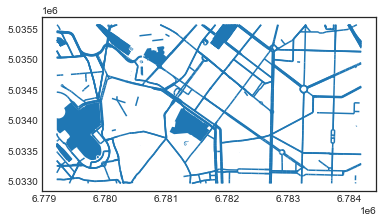

In [58]:
all_barriers.plot()

In [108]:
def eliminate_intersections(G, barrier_gdf):
    
    G_out = G.copy()
    
    # gdf_other = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_other), nodes=False, edges=True).to_crs(local_crs)
    barrier = barrier_gdf.geometry.unary_union
    
    for u, v, k, data in G.edges(data=True, keys=True):
        if data['geometry'].intersects(barrier):
            G_out.remove_edge(u, v)
                
    G_out = ox.utils_graph.remove_isolated_nodes(G_out)
    
    return G_out
    
    
    
    
    
#     to_drop = []

#     for u, v, k, data in G_in.edges(data=True, keys=True):
#         if data['geometry'].intersects(barrier):
#             to_drop.append([u, v, k])
            
#             print(to_drop)
#             break
            
#     for edge in to_drop:       
#         G_in.remove_edge(edge[0], edge[1])
    
#     G_in = ox.utils_graph.remove_isolated_nodes(G_in)
    
#     return G_in

In [110]:
if demo:
    print('demo')
    G_independent = eliminate_intersections(G_demo, all_barriers)
else:
    G_independent = eliminate_intersections(G, all_barriers)

demo


In [111]:
paths_independent = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_independent), nodes=False, edges=True).to_crs(local_crs)

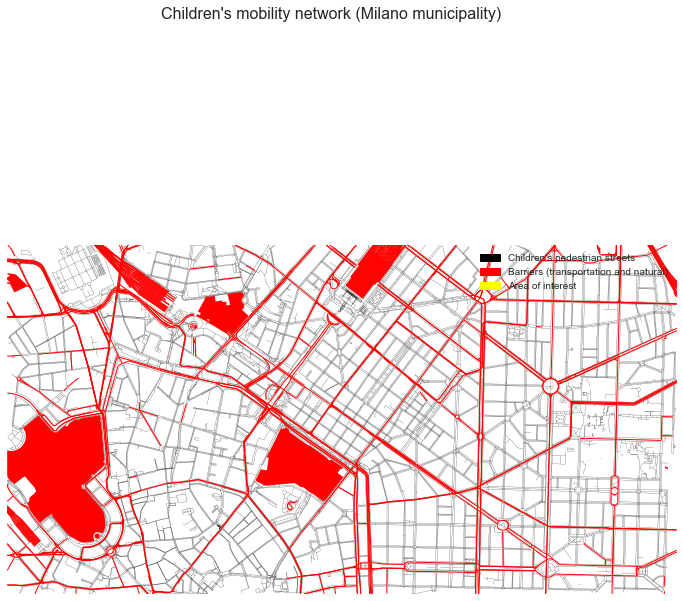

In [112]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
fig.suptitle('Children\'s mobility network ({} {})'.format(place_name, case_name), fontsize=16)

paths_independent.plot(ax=axs, figsize=(12, 20), color='black', linewidth=0.2, zorder=1)
all_barriers.plot(ax=axs, color='red', linewidth=1, zorder=2)

patch1 = mpatches.Patch(color='black', label='Children\'s pedestrian streets')
patch2 = mpatches.Patch(color='red', label='Barriers (transportation and natural)')
patch3 = mpatches.Patch(color='yellow', label='Area of interest')
handles = [patch1, patch2, patch3]
axs.legend(handles=handles)

if demo:
    bbox_plot = bbox.total_bounds
else:
    bbox_plot = place.total_bounds
margin = 0
xlim = ([bbox_plot[0]-margin, bbox_plot[2]+margin])
ylim = ([bbox_plot[1]-margin, bbox_plot[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.axis('off')
    
plt.show()

## Simplify network graph

### general pedestrian street network

In [116]:
if demo:
    G = G_demo
    paths = paths_demo

In [117]:
if tolerance > 0:
    G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=tolerance, dead_ends=True, reconnect_edges=True)
    print("After consolidating intersections with tolerance {}, {} out of {} nodes remain ({} %).".format(tolerance, len(G2), len(G), (round(100*len(G2)/len(G), 1))))
G = G2

After consolidating intersections with tolerance 10, 2433 out of 14385 nodes remain (16.9 %).


In [118]:
if tolerance > 0:
    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G2), nodes=False, edges=True).to_crs(local_crs)
    nodes = ox.utils_graph.graph_to_gdfs(G2, nodes=True, edges=False).to_crs(local_crs)
else:
    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True).to_crs(local_crs)
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False).to_crs(local_crs)

paths.reset_index(drop=True, inplace=True)
nodes.reset_index(drop=True, inplace=True)
nodes['_geom'] = nodes.geometry

### children's pedestrian street network

In [119]:
if tolerance > 0:
    G2_independent = ox.consolidate_intersections(G_independent, rebuild_graph=True, tolerance=tolerance, dead_ends=True, reconnect_edges=True)
    print("After consolidating intersections with tolerance {}, {} out of {} nodes remain ({} %).".format(tolerance, len(G2_independent), len(G_independent), (round(100*len(G2_independent)/len(G_independent), 1))))
G_independent = G2_independent

After consolidating intersections with tolerance 10, 2898 out of 11589 nodes remain (25.0 %).


In [120]:
if tolerance > 0:
    paths_independent = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G2_independent), nodes=False, edges=True).to_crs(local_crs)
    nodes_independent = ox.utils_graph.graph_to_gdfs(G2_independent, nodes=True, edges=False).to_crs(local_crs)
else:
    paths_independent = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_independent), nodes=False, edges=True).to_crs(local_crs)
    nodes_independent = ox.utils_graph.graph_to_gdfs(G_independent, nodes=True, edges=False).to_crs(local_crs)

paths_independent.reset_index(drop=True, inplace=True)
nodes_independent.reset_index(drop=True, inplace=True)
nodes_independent['_geom'] = nodes_independent.geometry

## Attractions

In [121]:
playground_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'playground_attraction.geojson'))
playground_attraction.crs = local_crs

small_park_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'small_park_attraction.geojson'))
small_park_attraction.crs = local_crs

In [143]:
if demo:
    playground_attraction = gpd.clip(playground_attraction, bbox)
    small_park_attraction = gpd.clip(small_park_attraction, bbox)

## Isochrones

### access to playgrounds

In [144]:
playground_general_access = playground_attraction.copy()
playground_general_access.geometry = playground_general_access.geometry.buffer(10)
get_isochrones(G, playground_general_access, trip_distances, local_crs)

In [145]:
playground_independent_access = playground_attraction.copy()
playground_independent_access.geometry = playground_independent_access.geometry.buffer(10)
get_isochrones(G_independent, playground_independent_access, trip_distances, local_crs)

### access to small parks

In [146]:
small_park_general_access = small_park_attraction.copy()
small_park_general_access.geometry = small_park_general_access.geometry.buffer(10)
get_isochrones(G, small_park_general_access, trip_distances, local_crs)

In [147]:
small_park_independent_access = small_park_attraction.copy()
small_park_independent_access.geometry = small_park_independent_access.geometry.buffer(10)
get_isochrones(G_independent, small_park_independent_access, trip_distances, local_crs)

### plot play space access for children: baseline vs. independently

In [148]:
trip_labels = []
for trip_distance in trip_distances:
    trip_labels.append('Within {}m walk'.format(trip_distance))

In [149]:
trip_labels_independent = []
for trip_distance in trip_distances:
    trip_labels_independent.append('Within an independent {}m walk'.format(trip_distance))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


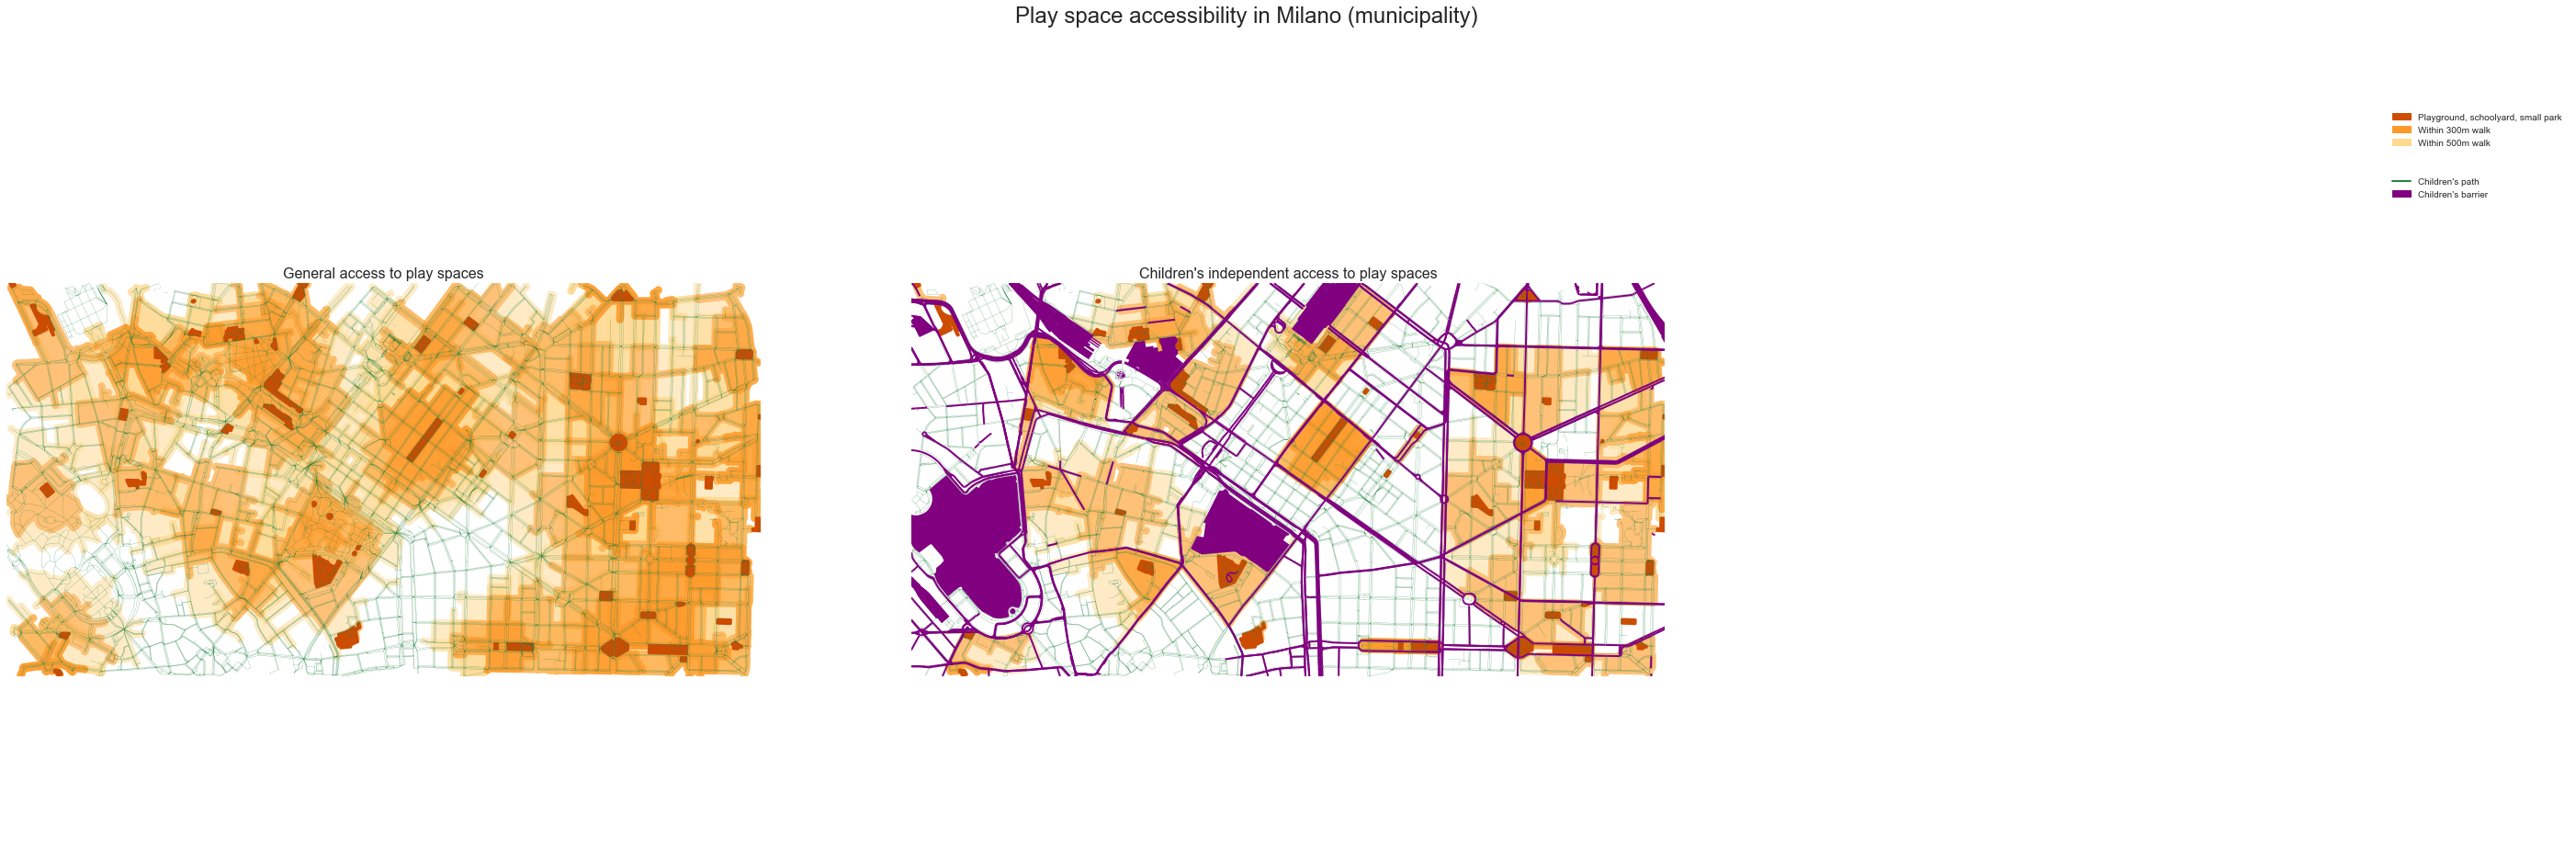

In [155]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(50,15))
fig.suptitle('Play space accessibility in {} ({})'.format(place_name, case_name), fontsize=24)

# general access
for i in range(len(trip_distances)):
    playground_general_access.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs[0], color=trip_colors_orange[i], zorder=len(trip_distances)-i, alpha=0.5)
    small_park_general_access.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs[0], color=trip_colors_orange[i], zorder=len(trip_distances)-i, alpha=0.5)
playground_general_access.plot(ax=axs[0], color=orange, zorder=4)
small_park_general_access.plot(ax=axs[0], color=orange, zorder=4)
paths.plot(ax=axs[0], color=green, linewidth=0.2, zorder=5)
place.plot(ax=axs[0], facecolor='none', edgecolor='yellow', linestyle='--', linewidth=5, zorder=6)
axs[0].set_title('General access to play spaces', fontsize=16)

# independent access
for i in range(len(trip_distances)):
    playground_independent_access.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs[1], color=trip_colors_orange[i], zorder=len(trip_distances)-i, alpha=0.5)
    small_park_independent_access.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs[1], color=trip_colors_orange[i], zorder=len(trip_distances)-i, alpha=0.5)
playground_independent_access.plot(ax=axs[1], color=orange, zorder=4)
small_park_independent_access.plot(ax=axs[1], color=orange, zorder=4)
paths_independent.plot(ax=axs[1], color=green, linewidth=0.2, zorder=5)
all_barriers.plot(ax=axs[1], color='purple', linewidth=2, zorder=5)
place.plot(ax=axs[1], facecolor='none', edgecolor='yellow', linestyle='--', linewidth=5, zorder=6)
axs[1].set_title('Children\'s independent access to play spaces', fontsize=16)

# create legend
handles = [mpatches.Patch(color=orange, label='Playground, schoolyard, small park')]
for i in range(len(trip_distances)):
    handles.append(mpatches.Patch(color=trip_colors_orange[i], label=trip_labels[i]))
handles.append(mpatches.Patch(color='None'))
# handles.append(mpatches.Patch(color=green, label='Small park'))
# for i in range(len(trip_distances)):
#     handles.append(mpatches.Patch(color=trip_colors_green[i], label=trip_labels[i]))
handles.append(mpatches.Patch(color='None'))

handles_independent = handles.copy()
handles.append(mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='Pedestrian path'))
handles_independent.append(mlines.Line2D([], [], color=green, linestyle='-', linewidth=2, label='Children\'s path'))
handles_independent.append(mpatches.Patch(color='purple', label='Children\'s barrier'))
    
# add legend
for ax in axs:
    ax.legend(loc='upper right')
# axs[0].legend(handles=handles)
# axs[1].legend(handles=handles_independent)
axs[2].legend(handles=handles_independent)

if demo:
    bbox_plot = bbox.total_bounds
else:
    bbox_plot = place.total_bounds
margin = 0
xlim = ([bbox_plot[0]-margin, bbox_plot[2]+margin])
ylim = ([bbox_plot[1]-margin, bbox_plot[3]+margin])

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')
    

plt.show()

#  Store output data

In [ ]:
output_file = os.path.join(output_folder, output_sub_folder, 'playground_general_access.geojson')
playground_general_access_out = playground_general_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playground_general_access_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_folder, output_sub_folder, 'small_park_general_access.geojson')
small_park_general_access_out = small_park_general_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
small_park_general_access_out.to_file(output_file, driver='GeoJSON')

In [ ]:
output_file = os.path.join(output_folder, output_sub_folder, 'playground_independent_access.geojson')
playground_independent_access_out = playground_independent_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playground_independent_access_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_folder, output_sub_folder, 'small_park_independent_access.geojson')
small_park_independent_access_out = small_park_independent_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
small_park_independent_access_out.to_file(output_file, driver='GeoJSON')